In [58]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from IPython.display import display, Markdown
from plotly.subplots import make_subplots
import textwrap
import os

# BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import openai
from bertopic.representation import OpenAI
from sklearn.metrics.pairwise import cosine_similarity

## **TABLE OF CONTENTS**:
- [DATASET](#dataset)
- [HOW TO USE](#how_to_use)
- [SEARCH DATASET](#search-dataset)
- [PARAMETERS BERTopic](#parameters)
- [LOAD DATA](#load-data)
- [EXECUTE BERT](#execute-bert)
- [ANALYZE CLUSTERS](#analyze-clusters)
  - [TOPIC BARCHART](#topic_barchart)
  - [TOPIC HIERARCHY](#topic_hierarchy)
  - [TOPIC DISTANCE MAP](#topic_distance)
- [MERGE CLUSTERS INTO DATASET](#merge_clusters)
- [TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER](#query_assign)
  - [ASSIGNED TOPICS WORDCLOUD](#topic_worldcloud)
- [VIZUALIZATIONS FOR ONE SPECIFIC TOPIC](#visual_one)
  - [PROJECTS IN TOPIC](#projects_topic)
  - [RELATED TOPICS](#topic_related)
- [VIZUALIZATIONS FOR MULTIPLE TOPICS](#visual_multiple)
  - [PROJECT COUNT OVER TIME](#project_count)
  - [FUNDING SCHEMES](#funding)
  - [DEPARTMENTS](#departments)
  - [SUB-DEPARTMENTS](#sub_departments)
  - [FUNDING SCHEMES IN DEPTH](#funding_depth)
- [COMPARING TWO TOPICS](#compare)
- [DEEP DIVE INTO TOPIC](#deep_dive)
- [SOURCES](#sources)

## **HOW TO USE** <a class="anchor" id="how_to_use"></a>
1. Select dataset, it should be cleaned with the provided code in the data_preprocessing folder.
2. Input a query, from your query topics will be assigned. Similarity will be calculated between your query and each topic representation, from this the top $n$ topics will be selected.
3. Set parametes for BERTopic. Note: some visualizations have also paramters, those can be changed at the specific visualizations. To easily find these parameters, they will be marked with <font color='red'>**PARAMETER**</font>.
4. Run the whole notebook.
5. Use table of contents to get desired info. Note: Some visualizations allow you to change the topics you want to visualize, where this can be done will be marked with <font color='red'>**SELECT**</font><br>


## **DATASET** <a class="anchor" id="dataset"></a>

In [59]:
DATASET = "../data/df_projects_merged.pkl" # dataset name / location
EXPORT_TOPICS = False # set to true if you want to export all topics
DF_TOPICS = "df_topics_info.csv" # set name for exported topics data (must be .csv)
EXPORT_TOPICS_MERGED = False # set to true if you want to export dataset with topics
DF_TOPICS_MERGED = "df_projects_merged_topics.csv" # set name for exported dataset with topics (must be .csv)

EXPORT_GRAPHS_CSV = True # set to true if you want to export all graphs data as csv files

## **SEARCH DATASET** <a class="anchor" id="search-dataset"></a>

In [60]:
# input your project query here, e.g. roman empire alexander the great greece
QUERY = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']

## **PARAMETERS BERTopic** <a class="anchor" id="parameters"></a>

Here are the parameters for BERTopic. We set them to the values that we believe are best.

In [61]:
# the model
LOAD_EMBEDDINGS = True  # set to True if embeddings are pre-saved
LOAD_MODEL = True  # set to True if a model is pre-saved
# the number of words per topic that you want to be extracted. These words are most representative of the topic.
N_WORDS_REPRESENTATION = 8
# the number of words you want in your topic representation. If you want 'Circular Economy' in your representations, set it to (1,2)
N_GRAM_RANGE = (1, 2)
# the minimum size of a topic. Lower means more topics, higher means less topics.
MIN_TOPIC_SIZE = 8

# assigning topics
TOPIC_COUNT = 8  # number of topics to identify; higher values will reduce accuracy
MIN_PROJECTS_CLUSTER = 0 # set higher to filter out topics with few projects

## **LOAD DATA** <a class="anchor" id="load-data"></a>

In [62]:
df_projects = pd.read_pickle(DATASET)

# filter only EU data
df_projects = df_projects[df_projects['project_source'].str.contains('eu', case=False)]

In [63]:
# nicer datafarme displays
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', 50)

print(df_projects.shape)
display(df_projects.head(2))

(12896, 9)


,project_source,display_name,project_id,funding,start_date,title,summary,text,cost
14785,cordis_eu_2007_2013_nl,EU_2007_2013,601714,FP7,2013-01-01,Translation of the direct-on-blood PCR-NALFIA ...,Accurate diagnosis of malaria is essential to ...,translation of the directonblood pcrnalfia sys...,2652374.0
14786,cordis_eu_2007_2013_nl,EU_2007_2013,223226,FP7,2009-01-01,Platform for the Harmonization of Vaccine Adju...,Adjuvants are critical to the quality and magn...,platform for the harmonization of vaccine adju...,300000.0


## **EXECUTE BERT** <a class="anchor" id="execute-bert"></a>

In [64]:
# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""

client = openai.OpenAI()
openai_model = OpenAI(client, model="gpt-3.5-turbo-0125", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    "OpenAI": openai_model
}

In [65]:
docs = list(df_projects.text.values) # create stacked list of abstracts

if LOAD_EMBEDDINGS:
    # load embeddings
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = np.load('embeddings/eu/embeddings.npy')
else:
    # pre-embed abstracts
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=True)

    # save embeddings
    save_dir = 'embeddings/eu/'
    os.makedirs(save_dir, exist_ok=True)
    np.save(os.path.join(save_dir, 'embeddings.npy'), embeddings)

In [66]:
if LOAD_MODEL:
    # load the BERTopic model
    topic_model = BERTopic.load("models/eu/BERTopic")

    # use the transform method to obtain topics and probabilities for the new documents
    topics, probs = topic_model.transform(docs, embeddings)
else:
    vectorizer_model = CountVectorizer(stop_words="english")
    
    topic_model = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=N_WORDS_REPRESENTATION,
                        n_gram_range=N_GRAM_RANGE,
                        min_topic_size=MIN_TOPIC_SIZE,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    # save the model
    save_dir = 'models/eu/'
    os.makedirs(save_dir, exist_ok=True)
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
    topic_model.save(os.path.join(save_dir, "BERTopic"), serialization="safetensors", save_embedding_model=embedding_model)

2024-06-29 09:42:23,285 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [67]:
# add chatgpt labels to the model
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

topic_model.get_topic_info().head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,4478,-1_research_project_european_new,Outlier Topic,"[research, project, european, new, development...",[European Research Development Data Systems],NaN
1,0,270,0_energy_buildings_renovation_building,Energy-Efficient Building Renovation,"[energy, buildings, renovation, building, effi...",[Energy-Efficient Building Renovation],NaN


## **ANALYZE CLUSTERS** <a class="anchor" id="analyze-clusters"></a>

In [68]:
# show most prominent topics
df_topic_info = topic_model.get_topic_info()
df_topic_info.head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,4478,-1_research_project_european_new,Outlier Topic,"[research, project, european, new, development...",[European Research Development Data Systems],NaN
1,0,270,0_energy_buildings_renovation_building,Energy-Efficient Building Renovation,"[energy, buildings, renovation, building, effi...",[Energy-Efficient Building Renovation],NaN


In [69]:
if EXPORT_TOPICS is True:
    df_topic_info.to_csv(DF_TOPICS, index=False)

**Topic -1 are outliers**

#### **TOPIC BARCHART** <a class="anchor" id="topic_barchart"></a>

In [70]:
topic_model.visualize_barchart(top_n_topics=8, n_words=20, custom_labels=True, width=400)

#### **TOPIC HIERARCHY** <a class="anchor" id="topic_hierarchy"></a>

This plot shows the cluster hierarchy. Since we use HDBSCAN as a clustering algorthim, this means that clusters within clusters can be formed, to understand how these are related to each other we can use the plot below. A color indicates clusters that are closer related to each other. These are then broken down to smaller clusters with more specific topics.

In [71]:
# topic_model.visualize_hierarchy(custom_labels=True)

#### **TOPIC DISTANCE MAP** <a class="anchor" id="topic_distance"></a>

This graph shows the 2D representation of the clusters, where the y-axis is the first dimensionality and the x-axis the second dimensionality.

Use the slider to select a topic, which will then light up. Hovering over a topic will give the topic size and its label. If you hold and drag with your mouse pointer you can zoom into the map to analyze the cluster structure.

In [72]:
topic_model.visualize_topics(custom_labels=True)

## **MERGE CLUSTERS INTO DATASET** <a class="anchor" id="merge_clusters"></a>

In [73]:
df_projects = pd.read_pickle(DATASET)

# filter only EU data
df_projects = df_projects[df_projects['project_source'].str.contains('eu', case=False)]
df_projects = df_projects.copy()

In [74]:
df_projects['Topic'] = topics
df_projects.head(1)

,project_source,display_name,project_id,funding,start_date,title,summary,text,cost,Topic
14785,cordis_eu_2007_2013_nl,EU_2007_2013,601714,FP7,2013-01-01,Translation of the direct-on-blood PCR-NALFIA ...,Accurate diagnosis of malaria is essential to ...,translation of the directonblood pcrnalfia sys...,2652374.0,110


In [75]:
df_projects['Topic'] = df_projects['Topic'].astype(int)

df_projects = pd.merge(df_projects, df_topic_info[['Topic', 'Representation', 'CustomName']], left_on='Topic', right_on='Topic', how='left')

In [76]:
df_projects.head(1)

,project_source,display_name,project_id,funding,start_date,title,summary,text,cost,Topic,Representation,CustomName
0,cordis_eu_2007_2013_nl,EU_2007_2013,601714,FP7,2013-01-01,Translation of the direct-on-blood PCR-NALFIA ...,Accurate diagnosis of malaria is essential to ...,translation of the directonblood pcrnalfia sys...,2652374.0,110,"[pointofcare, antibiotic, diagnostic, diagnost...",Advanced Point-of-Care Diagnostics


In [77]:
if EXPORT_TOPICS_MERGED is True:
    df_projects.to_csv(DF_TOPICS_MERGED, index=False)

In [78]:
# functions to print in markdown
def print_markdown(md_string):
    display(Markdown(md_string))
    
def print_markdown_list(items):
    md_string = ""
    for item in items:
        md_string += f"- ##### {item}\n"
    display(Markdown(md_string))

## **TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER** <a class="anchor" id="query_assign"></a>

These are the topics related to your query. Your query is firstly embedded, and then used to calculate the cosine similarity with each topic representation. The top $n$ topics are then shown. The number of topics shown can be changed at the top of the notebook.

In [79]:
print_markdown(f"### Input query:\n##### {QUERY[0]}")

similar_topics, similarity = topic_model.find_topics(QUERY[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics}\n")
TOPICS = [topic for topic in similar_topics if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Input query:
##### sustainability industry innovation process technology innovation raw materials circularity consumption goods

### Topics found (numbers):
##### [96, 216, 4, 152, 136, 189, 206, 180]


### Topics, ranked top to bottom, match with query:


- ##### (96): Circular Economy Impact Assessment
- ##### (216): Circular Construction Solutions
- ##### (4): Sustainable Plastic Recycling Innovations
- ##### (152): Sustainable Biobased Certification Systems
- ##### (136): European Rare Earth Recycling
- ##### (189): Green Transition Pathways Analysis
- ##### (206): Aerospace Clustering Innovation Chains
- ##### (180): European Raw Materials Network


#### **ASSIGNED TOPICS WORDCLOUD** <a class="anchor" id="topic_worldcloud"></a>

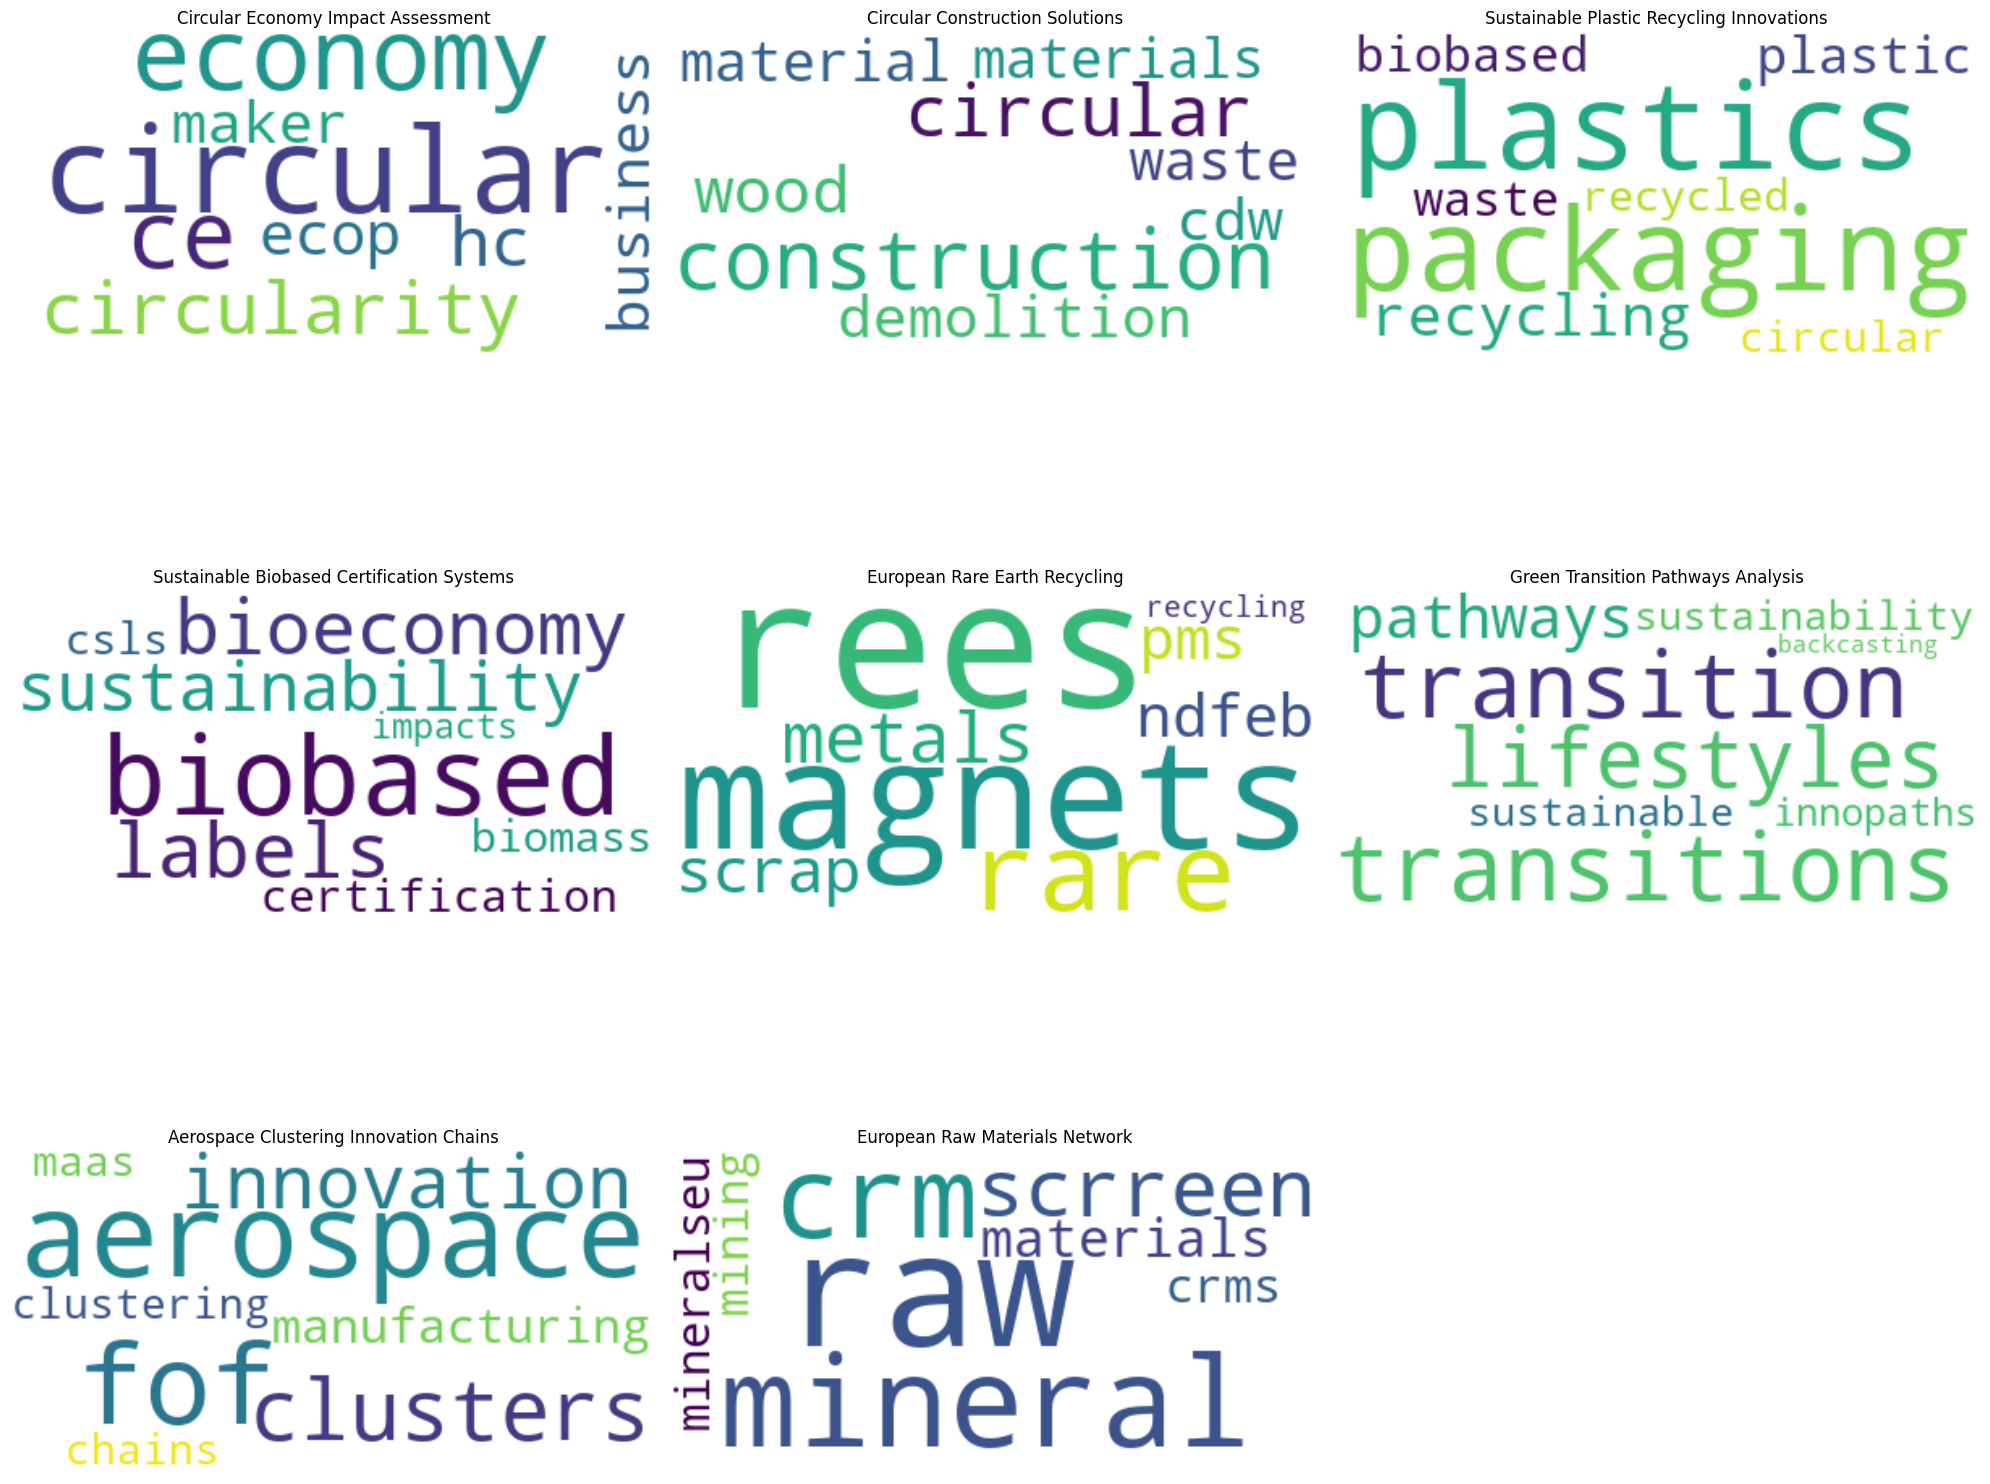

In [80]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    return wc.generate_from_frequencies(text)

# generate and plot each word cloud
cols = 3
rows = (len(TOPICS) + cols - 1) // cols
plt.figure(figsize=(20, 6 * rows))

for index, topic in enumerate(TOPICS):
    plt.subplot(rows, cols, index + 1)
    wc = create_wordcloud(topic_model, topic=topic)
    
    # retrieve the custom name for the topic
    topic_projects = df_projects[df_projects['Topic'] == topic]
    if not topic_projects.empty:
        title = topic_projects['CustomName'].iloc[0]
    else:
        title = f"Topic {topic}"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

## **VIZUALIZATIONS FOR ONE SPECIFIC TOPIC** <a class="anchor" id="visual_one"></a>

How to use: Choose a single topic you want to visualize, pick one number from the topics that where assigned to your query. By default this will be the topic that best matched your query. The topics found are listed here again below:

In [81]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (96): Circular Economy Impact Assessment
- ##### (216): Circular Construction Solutions
- ##### (4): Sustainable Plastic Recycling Innovations
- ##### (152): Sustainable Biobased Certification Systems
- ##### (136): European Rare Earth Recycling
- ##### (189): Green Transition Pathways Analysis
- ##### (206): Aerospace Clustering Innovation Chains
- ##### (180): European Raw Materials Network


##### <font color='red'>**SELECT**</font><br>

In [82]:
SELECTED_TOPIC_ID = TOPICS[0] # choose topic for visualizations, default is best match with query (the top one). Example input: SELECTED_TOPIC_ID = 35

In [83]:
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### Selected topic is: ({SELECTED_TOPIC_ID}): {SELECTED_TOPIC_NAME}')

### Selected topic is: (96): Circular Economy Impact Assessment

#### **PROJECTS IN TOPIC** <a class="anchor" id="projects_topic"></a>

##### <font color='red'>**PARAMETER**</font>

In [84]:
THRESHOLD_DOC_PROB_TABLE = 0.1  # adjust the threshold based on your needs, docs below the trehshold will not be shown

In [85]:

topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### This table shows the likelihood that projects belong to Topic ({SELECTED_TOPIC_ID}) {SELECTED_TOPIC_NAME}:')

# extract the probabilities for the specific topic
if LOAD_MODEL:
    specific_topic_probs = probs[:, TOPIC_INDEX]
else:
    specific_topic_probs = probs[:, SELECTED_TOPIC_ID]

# find documents with a probability above the threshold
doc_indices = np.where(specific_topic_probs >= THRESHOLD_DOC_PROB_TABLE)[0]

docs_with_specific_topic = [docs[i] for i in doc_indices]

df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# sort the dataframe in descending order
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

# nicer dataframe displays
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 500)

display(df_specific_topic.head(5))

# create dataframe with only top 10 documents
df_specific_topic_top_n = df_specific_topic.head(10)

# truncate documents to threshold
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 140)

fig = go.Figure(data=[
    go.Bar(
        y=df_specific_topic_top_n.index,
        x=df_specific_topic_top_n['probability'],
        text=df_specific_topic_top_n['document'],
        textposition='inside',
        insidetextanchor='end',
        orientation='h',
        marker_color='skyblue'
    )
])

fig.update_layout(
    title_text=f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})',
    xaxis_title=f'Probability of matching to topic {SELECTED_TOPIC_ID}',
    yaxis_title='Projects',
    yaxis_autorange="reversed"
)

fig.show()

### This table shows the likelihood that projects belong to Topic (96) Circular Economy Impact Assessment:

,document,probability
0,realising the transition to the circular economy models methods and applications this network brings together an exceptionally strong team of worldleading experts from a wide set of beneficiaries and partners in order to achieve breakthroughs in understanding how the transition towards a circular economy ce can be realised in a successful way in the european context both within existing organisations and industries as well as through innovative and sustainable business models the proposed ap...,0.86
1,european community of practice supporting hubs for circularity hc ecop hubs for circularity hc are to be the european lighthouses of resource efficiency through implementing best practice in industrial and urban symbiosis ius the hc are intended to achieve a step change in circular utilisation of resources and ghg emission reductions within given geographic areas the european community of practice ecop builds on and brings together ongoing work and expertise on hc and ius initially supportin...,0.84
2,circular european economy innovative training network circuit the circular european economy innovative training network creates a cohort of future leaders in research policy business through its innovative training programme focused on the circular economy circular business models based on leasing or providing functionality rather than products often called product services systems are widely seen as a way how business can create sustainable jobs and growth the ellen macarthur foundation emf...,0.84
3,transitioning towards an efficient carbonneutral circular european industry the need to approach climate action resource efficiency and circularity performance as integrated economywide crosscutting issues is growingly gaining attention in the policy world stimulating the development of new industrial policies in europe and worldwide currently however there is little progress in conceptualising the circular economy and understanding its interactions with climate action stateoftheart modellin...,0.83
4,sustainable circular economy transition from industrial symbiosis to hubs for circularity existing heavily industrialized areas are currently incapable of adopting largescale industrial symbioses in terms of shared technologyinfrastructure use waste integration energy and material utilization as well as expanding through surrounding ecosystems in an inclusive manner for the society despite many of the eus key strategic priorities in sustainable regional development within this context ishc p...,0.83


##### <font color='red'>**SELECT**</font><br>

In [86]:
# SELECTED_PROJECT_ID refers to the IDs shown in the figure above which is based relative to your selected topic (this is not the original project ID)
SELECTED_PROJECT_ID = 0

In [87]:
document_text = df_specific_topic['document'][SELECTED_PROJECT_ID]

document_text = textwrap.fill(document_text, width=200)
print(document_text)

realising the transition to the circular economy models methods and applications this network brings together an exceptionally strong team of worldleading experts from a wide set of beneficiaries and
partners in order to achieve breakthroughs in understanding how the transition towards a circular economy ce can be realised in a successful way in the european context both within existing
organisations and industries as well as through innovative and sustainable business models the proposed approach is inherently multidisciplinary drawing upon research that will advance significantly
the stateoftheart in terms of the current understanding of the applicability of the ce paradigm from economic environmental and social points of view providing policy insights and implications for
practice the consortium of beneficiaries including academic and nonacademic groups will design and deliver world class multidisciplinary training to early stage researchers esrs offering them an
extended and valuab

#### **RELATED TOPICS** <a class="anchor" id="topic_related"></a>

In [88]:
# topic embeddings
topic_embeddings = topic_model.topic_embeddings_
specific_topic_embedding = topic_embeddings[TOPIC_INDEX].reshape(1, -1)

# compute the cosine similarity
similarities = cosine_similarity(specific_topic_embedding, topic_embeddings).flatten()
distances = 1 - similarities
distances = np.round(distances, 2)

# sort the distances
sorted_indices = np.argsort(distances)

topic_info = topic_model.get_topic_info().loc[sorted_indices].iloc[:, :5]

topic_info.rename(columns={'Count': 'document_count'}, inplace=True)

topic_info['distance'] = distances[sorted_indices]

print_markdown(f'### This table shows a list of topics that are closest to topic {SELECTED_TOPIC_ID} usig cosine similarity:')

display(topic_info.head(10))

### This table shows a list of topics that are closest to topic 96 usig cosine similarity:

,Topic,document_count,Name,CustomName,Representation,distance
97,96,30,96_circular_economy_ce_circularity,Circular Economy Impact Assessment,"[circular, economy, ce, circularity, hc, ecop, business, maker]",0.00
190,189,15,189_transitions_transition_lifestyles_pathways,Green Transition Pathways Analysis,"[transitions, transition, lifestyles, pathways, sustainability, sustainable, innopaths, backcasting]",0.20
207,206,13,206_aerospace_fof_clusters_innovation,Aerospace Clustering Innovation Chains,"[aerospace, fof, clusters, innovation, manufacturing, clustering, chains, maas]",0.23
1,0,270,0_energy_buildings_renovation_building,Energy-Efficient Building Renovation,"[energy, buildings, renovation, building, efficiency, residential, construction, financing]",0.24
106,105,29,105_bioeconomy_biobased_rural_regional,European Bioeconomy Innovation Integration,"[bioeconomy, biobased, rural, regional, regions, innovation, circular, engagement]",0.26
153,152,19,152_biobased_labels_bioeconomy_sustainability,Sustainable Biobased Certification Systems,"[biobased, labels, bioeconomy, sustainability, certification, biomass, csls, impacts]",0.27
26,25,62,25_climate_adaptation_change_mitigation,Climate Resilience and Mitigation Framework,"[climate, adaptation, change, mitigation, policy, impacts, action, risks]",0.28
224,223,12,223_ccs_eccsel_capture_storage,European CCS Infrastructure Development,"[ccs, eccsel, capture, storage, ccus, ecco, infrastructure, eric]",0.28
218,217,12,217_innovation_social_ntms_catchingup,Social Innovation Policy Framework,"[innovation, social, ntms, catchingup, policy, sirene, catchup, economic]",0.28
212,211,13,211_ssh_ris_eric_erics,Strengthening SSH Research Infrastructures,"[ssh, ris, eric, erics, ri, esfri, rivis, infrastructures]",0.28


##### <font color='red'>**PARAMETER**</font>

In [89]:
# set minimal distance (cosine similarity) fo find closest related topics
MIN_DISTANCE = 0.3

In [90]:
# show other topics that are closest related
closest_topics = topic_info[topic_info['distance'] < MIN_DISTANCE]['Topic']
title_barchart = f'Topics with cosine distance < {MIN_DISTANCE} with Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})'
topic_model.visualize_barchart(title=title_barchart, topics=closest_topics, n_words=15, custom_labels=True, width=450, height=300)

## **VIZUALIZATIONS FOR MULTIPLE TOPICS** <a class="anchor" id="visual_multiple"></a>

Choose multiple topics you want to visualize, in python list format. By default this will be the all the topics. The topics matched with your query are listed here again below:

In [91]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (96): Circular Economy Impact Assessment
- ##### (216): Circular Construction Solutions
- ##### (4): Sustainable Plastic Recycling Innovations
- ##### (152): Sustainable Biobased Certification Systems
- ##### (136): European Rare Earth Recycling
- ##### (189): Green Transition Pathways Analysis
- ##### (206): Aerospace Clustering Innovation Chains
- ##### (180): European Raw Materials Network


##### <font color='red'>**SELECT**</font> AND <font color='red'>**PARAMETER**</font><br>

In [92]:
# Choose your topic IDs:
SELECTED_TOPIC_IDS = TOPICS[:10]

# visualizations
START_YEAR = 2015  # start year for generating visualizations
END_YEAR = 2023  # end year for generating visualizations

In [93]:
print_markdown('### The selected topics are:')
topics_list = []
for topic_id in SELECTED_TOPIC_IDS:
    TOPIC_INDEX = topic_id + 1
    SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
    topics_list.append(f'({topic_id}): {SELECTED_TOPIC_NAME}')
    
print_markdown_list(topics_list)

### The selected topics are:

- ##### (96): Circular Economy Impact Assessment
- ##### (216): Circular Construction Solutions
- ##### (4): Sustainable Plastic Recycling Innovations
- ##### (152): Sustainable Biobased Certification Systems
- ##### (136): European Rare Earth Recycling
- ##### (189): Green Transition Pathways Analysis
- ##### (206): Aerospace Clustering Innovation Chains
- ##### (180): European Raw Materials Network


#### **PROJECT COUNT OVER TIME** <a class="anchor" id="project_count"></a>

In [94]:
# convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

# group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

line_fig = go.Figure()

topic_data = filtered_data.drop_duplicates(subset=['Topic'])

for topic in SELECTED_TOPIC_IDS:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

line_fig.update_layout(
    title='Project Count by Topic Over Time',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

line_fig.show()

if EXPORT_GRAPHS_CSV:
    grouped_data.to_csv('graph_exports/merged/project_count_by_topic_over_time.csv')

#### **FUNDING SCHEMES** <a class="anchor" id="funding"></a>

In [95]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])['project_id'].count().unstack(fill_value=0)
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    line_fig.update_layout(
        title=f'Project Count by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time',
        xaxis_title='Year',
        yaxis_title='Number of Projects',
        legend_title=column_name
    )
    
    line_fig.show()
    
    if EXPORT_GRAPHS_CSV:
        safe_column_name = column_name.replace('/', '_').replace('\\', '_')
        grouped_data.to_csv(f'graph_exports/merged/project_count_by_top_{top_n}_{safe_column_name}_over_time.csv')


plot_top_n_schemes(
    df=df_projects,
    column_name='funding',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=10,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

#### **FUNDING SCHEMES IN DEPTH** <a class="anchor" id="funding_depth"></a>

##### <font color='red'>**PARAMETER**</font>

In [96]:
MAX_CHARACTERS_FUNDING = 4 # truncate the names of the funding schemes to n characters

## **VIZUALIZATIONS SELECTED TOPIC IDS** <a class="anchor" id="SELECTED TOPIC IDS"></a>

##### <font color='red'>**PARAMETER**</font>

In [97]:
MAX_CHARACTERS = 4 # truncate the name of the funding schemes to n characters
TOP_N_FUNDINGSCHEMES = 12 # select the n top funding schemes in the dataset

In [98]:
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

filtered_topics_ = filtered_topics.copy()

# step 1: truncate funding scheme names
filtered_topics_ = filtered_topics_[filtered_topics_['funding'] != 'Outlier Topic']
filtered_topics_['funding_scheme_truncated'] = filtered_topics_['funding'].str.slice(0, MAX_CHARACTERS)

# step 1: identify the top 12 funding schemes
top_funding_schemes = filtered_topics_['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# step 2: create a subplot grid with 6 rows and 2 columns
fig = make_subplots(rows=6, cols=2, subplot_titles=top_funding_schemes)

# map topics to their representative words
topic_labels = {topic: ''.join(words) for topic, words in topic_model.get_topic_info().set_index('Topic')['CustomName'].to_dict().items()}

# function to create a bar chart for a given funding scheme
def add_bar_chart(fig, funding_scheme, row, col):
    # filter the topic_counts dataframe for the specified funding_scheme
    filtered_topic_counts = filtered_topics_[filtered_topics_['funding_scheme_truncated'] == funding_scheme]

    # count the frequency of topics for the specified funding_scheme
    topic_counts = filtered_topic_counts['Topic'].value_counts().reset_index().head(15)
    topic_counts.columns = ['Topic', 'Frequency']

    # sort values by frequency
    topic_counts = topic_counts.sort_values(by='Frequency', ascending=True)

    fig.add_trace(go.Bar(
        y=[topic_labels[topic] for topic in topic_counts['Topic']],
        x=topic_counts['Frequency'],
        orientation='h'
    ), row=row, col=col)

# step 3: iterate over the top funding schemes and add a bar chart for each
for idx, funding_scheme in enumerate(top_funding_schemes):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_bar_chart(fig, funding_scheme, row, col)

fig.update_layout(
    height=1800,  # adjust height to fit 6 rows
    width=2000,
    title_text="Topics for Top 12 Funding Schemes",
    showlegend=False  # hide the legend to avoid clutter
)

fig.show()

##### <font color='red'>**PARAMETER**</font>

In [99]:
MAX_CHARACTERS = 4 # truncate the name of the funding schemes to n characters
TOP_N_FUNDINGSCHEMES = 12 # select the n top funding schemes in the dataset

In [100]:
df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects['funding'].str.slice(0, MAX_CHARACTERS)

# filter dataframe to only include top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# filter dataframe to only include top 25 topics
top_25_topics = df_top_funding_schemes['CustomName'].value_counts().head(25).index.tolist()
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName'].isin(top_25_topics)]

# create a pivot table to count the frequency of topics per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName', columns='funding_scheme_truncated', aggfunc='count', fill_value=0)

# custom colors
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Topic Frequencies by Top Funding Schemes',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Funding Scheme",
    yaxis_title="Topic"
)

fig.show()

if EXPORT_GRAPHS_CSV:
    heatmap_data.to_csv('graph_exports/merged/heatmap_topic_frequencies_by_top_funding_schemes.csv', index=False)

In [101]:
df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# parse start_date to extract year
df_cleaned_projects['year'] = pd.to_datetime(df_cleaned_projects['start_date']).dt.year

# filter dataframe to only include top 25 topics
top_25_topics = df_cleaned_projects['CustomName'].value_counts().head(25).index.tolist()
df_top_topics = df_cleaned_projects[df_cleaned_projects['CustomName'].isin(top_25_topics)]

# create a pivot table to count the frequency of topics per year
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName', columns='year', aggfunc='count', fill_value=0)

# custom colors
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Selected Topic Frequencies by Year',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Year",
    yaxis_title="Topic"
)

fig.show()

if EXPORT_GRAPHS_CSV:
    heatmap_data.to_csv('graph_exports/merged/heatmap_selected_topic_frequencies_by_year.csv', index=False)

## **COMPARING TWO TOPICS** <a class="anchor" id="compare"></a>

If you want to compare to different topics you can input two different queries here.

##### <font color='red'>**SELECT**</font><br>

In [102]:
QUERY_1 = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']
QUERY_2 = ["ai artifical intelligence"]

In [103]:

print_markdown(f"### Input query 1:\n##### '{QUERY_1[0]}'\n")
print_markdown(f"### Input query 2:\n##### '{QUERY_2[0]}'\n")

similar_topics_1, similarity_1 = topic_model.find_topics(QUERY_1[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics_1}\n")
TOPICS_1 = [topic for topic in similar_topics_1 if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]
similar_topics_2, similarity_2 = topic_model.find_topics(QUERY_2[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics_2}\n")
TOPICS_2 = [topic for topic in similar_topics_2 if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print_markdown("### Topics, ranked top to bottom, match with query 1:")
topics_list = []
for i in TOPICS_1:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")
print_markdown_list(topics_list)
            
print_markdown("\n ### Topics, ranked top to bottom, match with query 2:")
topics_list = []
for i in TOPICS_2:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")
print_markdown_list(topics_list)

### Input query 1:
##### 'sustainability industry innovation process technology innovation raw materials circularity consumption goods'


### Input query 2:
##### 'ai artifical intelligence'


### Topics found (numbers):
##### [96, 216, 4, 152, 136, 189, 206, 180]


### Topics found (numbers):
##### [80, 173, 93, 1, 219, 101, 9, 169]


### Topics, ranked top to bottom, match with query 1:

- ##### (96): Circular Economy Impact Assessment
- ##### (216): Circular Construction Solutions
- ##### (4): Sustainable Plastic Recycling Innovations
- ##### (152): Sustainable Biobased Certification Systems
- ##### (136): European Rare Earth Recycling
- ##### (189): Green Transition Pathways Analysis
- ##### (206): Aerospace Clustering Innovation Chains
- ##### (180): European Raw Materials Network



 ### Topics, ranked top to bottom, match with query 2:

- ##### (80): European Human-Centric AI Excellence
- ##### (173): Intelligent Service Robots for Aging
- ##### (93): Agricultural Robotics Solutions
- ##### (1): Collaborative Manufacturing Robotics Solution
- ##### (219): Emotional Virtual Reality Presence
- ##### (101): Advanced Semantic Modal Logics
- ##### (9): Neural mechanisms of visual perception
- ##### (169): European Edge AI Initiatives


##### <font color='red'>**SELECT**</font><br>

In [104]:
# select topics you want to compare, you can use list slicing or simply write the lists out: e.g. TOPICS_1 = [35, 36, 37]
TOPICS_1_SELECT = TOPICS_1[:3]
TOPICS_2_SELECT =TOPICS_2[:3]

TOPICS_COMPARE = TOPICS_1_SELECT + TOPICS_2_SELECT

In [105]:
# convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# filter data based on date and topic selection
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS_COMPARE))]

# group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

line_fig = go.Figure()

topic_data = filtered_data.drop_duplicates(subset=['Topic'])

# colors for TOPICS_1 and TOPICS_2
colors = {topic: 'rgba(99,110,251,1)' for topic in TOPICS_1}
colors.update({topic: 'rgba(239,86,59,1)' for topic in TOPICS_2})

for topic in TOPICS_COMPARE:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

# aggregated lines for TOPICS_1 and TOPICS_2
grouped_data['TOPICS_1_SUM'] = grouped_data[TOPICS_1_SELECT].sum(axis=1)
grouped_data['TOPICS_2_SUM'] = grouped_data[TOPICS_2_SELECT].sum(axis=1)

line_fig.add_trace(go.Scatter(
    x=grouped_data.index,
    y=grouped_data['TOPICS_1_SUM'],
    name='Aggregate TOPICS_1',
    mode='lines',
    line=dict(color='rgba(0,200,200,1)', width=2, dash='dash')
))

line_fig.add_trace(go.Scatter(
    x=grouped_data.index,
    y=grouped_data['TOPICS_2_SUM'],
    name='Aggregate TOPICS_2',
    mode='lines',
    line=dict(color='rgba(200,0,200,1)', width=2, dash='dash')
))

line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='Topic'
)

# function to update the visibility of traces
def update_visibility(trace_index, visibility):
    line_fig.data[trace_index].visible = visibility

# buttons
buttons = [
    dict(
        label='Show Aggregate Lines',
        method='restyle',
        args=['visible', [True if i in [len(line_fig.data)-2, len(line_fig.data)-1] else False for i in range(len(line_fig.data))]]
    ),
    dict(
        label='Show Separate Lines',
        method='restyle',
        args=['visible', [True if i not in [len(line_fig.data)-2, len(line_fig.data)-1] else False for i in range(len(line_fig.data))]]
    )
]

# layout for buttons
line_fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=buttons,
            x=1.35,  # x position of the buttons (1 is the far right of the plot)
            y=1.2,  # y position of the buttons (1 is the top of the plot)
            xanchor='right',
            yanchor='top',
        )
    ]
)

line_fig.show()

if EXPORT_GRAPHS_CSV:
    grouped_data.to_csv('graph_exports/merged/compare_project_count_by_topic_over_time.csv')

## **SOURCES** <a class="anchor" id="sources"></a>
<ol>
  <li>Grootendorst, M. (n.d.). <em>Topics per class using BERTopic</em>. Retrieved from <a href="https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640">https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640</a></li>
  <li>Grootendorst, M. (n.d.). <em>Parameter Tuning</em>. BERTopic. Retrieved from <a href="https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html">https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html</a></li>
  <li>Anonymous. (n.d.). <em>OpenAI Integration</em>. Google Colab. Retrieved from <a href="https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD">https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD</a></li>
</ol>
